In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

trivikramu_optriae_path = kagglehub.dataset_download('trivikramu/optriae')
trivikramu_oprita_path = kagglehub.dataset_download('trivikramu/oprita')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# STEP 1: Install Python 3.8 and create virtual environment
!sudo apt-get update
!sudo apt-get install -y python3.8 python3.8-venv python3.8-dev

# STEP 2: Create and activate the virtual environment
!python3.8 -m venv py38env
!py38env/bin/pip install --upgrade pip setuptools wheel

# STEP 3: Install compatible packages
!py38env/bin/pip install scikit-learn==0.24.2
!py38env/bin/pip install auto-sklearn
!py38env/bin/pip install openml
!py38env/bin/pip install  matplotlib seaborn
# !py38env/bin/pip install  pandas



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [5]:
code="""
if __name__ == "__main__":
    import openml
    import autosklearn.classification
    import sklearn.ensemble
    import sklearn.svm
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import balanced_accuracy_score
    import numpy as np
    import pandas as pd
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import os

    # === Setup ===
    dataset_id = 1049  # Promise pc4
    os.makedirs("plots", exist_ok=True)

    # Load dataset
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    X_train = X_train.copy()
    X_test = X_test.copy()

    # === AutoSklearn Training ===
    automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=1800,
        per_run_time_limit=120,
        include={"classifier": ['random_forest', 'gradient_boosting', 'libsvm_svc']},
        resampling_strategy='holdout',
        metric=autosklearn.metrics.balanced_accuracy,
        seed=42
    )

    automl.fit(X_train, y_train)

    # Extract BER over time
    results = automl.cv_results_
    df_auto = pd.DataFrame({
        "time": results["mean_fit_time"],
        "ber": 1 - results["mean_test_score"]
    }).sort_values("time")

    # === Baseline Models ===
    def get_ber(model, name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        ber = 1 - balanced_accuracy_score(y_test, y_pred)
        return ber

    rf_ber = get_ber(sklearn.ensemble.RandomForestClassifier(), "Random Forest")
    gb_ber = get_ber(sklearn.ensemble.GradientBoostingClassifier(), "Gradient Boosting")
    svm_ber = get_ber(sklearn.svm.SVC(kernel="rbf"), "Kernel SVM")

    # === Plot ===
    plt.figure(figsize=(10, 6))
    plt.plot(df_auto["time"], df_auto["ber"], label="auto-sklearn", color="black", marker="o", linewidth=2)

    for label, ber, color in [
        ("random forest", rf_ber, "green"),
        ("gradient boosting", gb_ber, "red"),
        ("kernel SVM", svm_ber, "blue")
    ]:
        plt.hlines(ber, xmin=min(df_auto["time"]), xmax=max(df_auto["time"]),
                   colors=color, linestyles="dashed", label=label)

    plt.xlabel("Time [sec]")
    plt.ylabel("Balanced Error Rate (BER)")
    plt.xscale("log")
    plt.ylim(bottom=0)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.title("AutoSklearn vs Baselines on OpenML Dataset 1049 (pc4)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("plots/autosklearn_vs_baselines_dataset1049.png")


"""

# Save the code to a Python script file
with open("autosklearn_vs_baselines_1049.py", "w") as f:
    f.write(code)

# Step 4: Run the script using the virtual environment
# !py38env/bin/python autosklearn_test.py


!py38env/bin/python autosklearn_vs_baselines_1049.py


[WARNING] [2025-05-01 11:31:48,870:Client-AutoMLSMBO(42)::ddad1c22-267f-11f0-968d-0242ac1c000c] Configuration 29 not found
[WARNING] [2025-05-01 11:31:48,871:Client-AutoMLSMBO(42)::ddad1c22-267f-11f0-968d-0242ac1c000c] Configuration 428 not found
[WARNING] [2025-05-01 11:31:48,871:Client-AutoMLSMBO(42)::ddad1c22-267f-11f0-968d-0242ac1c000c] Configuration 673 not found
[WARNING] [2025-05-01 11:31:48,871:Client-AutoMLSMBO(42)::ddad1c22-267f-11f0-968d-0242ac1c000c] Configuration 263 not found
[WARNING] [2025-05-01 11:31:48,871:Client-AutoMLSMBO(42)::ddad1c22-267f-11f0-968d-0242ac1c000c] Configuration 650 not found
[WARNING] [2025-05-01 11:31:48,871:Client-AutoMLSMBO(42)::ddad1c22-267f-11f0-968d-0242ac1c000c] Configuration 5 not found
[WARNING] [2025-05-01 11:31:48,872:Client-AutoMLSMBO(42)::ddad1c22-267f-11f0-968d-0242ac1c000c] Configuration 513 not found
[WARNING] [2025-05-01 11:31:48,872:Client-AutoMLSMBO(42)::ddad1c22-267f-11f0-968d-0242ac1c000c] Configuration 668 not found
[WARNING] [

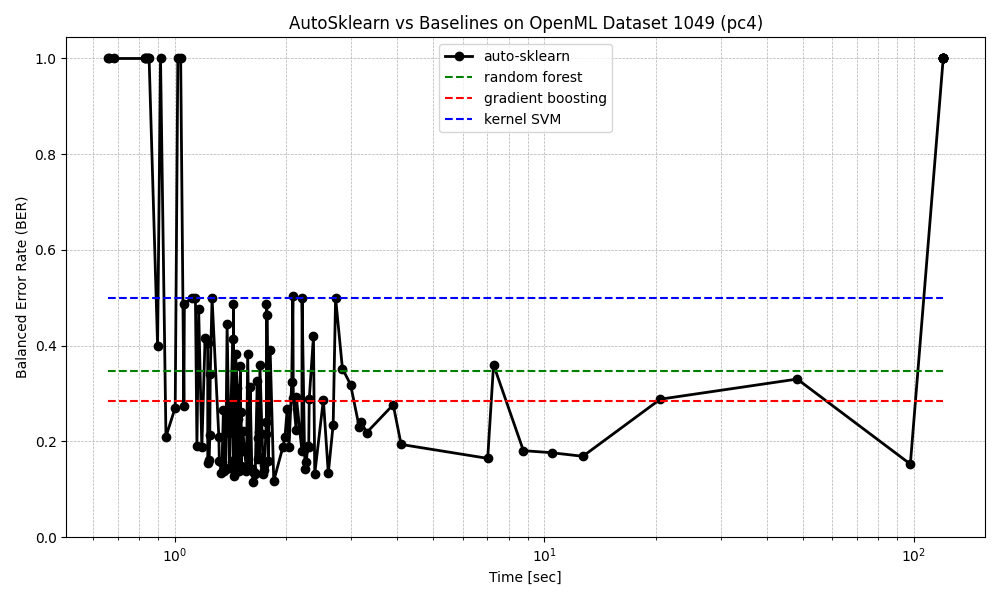

In [6]:
from IPython.display import Image, display
display(Image("plots/autosklearn_vs_baselines_dataset1049.png"))


In [ ]:
# # Save this mini script
# with open("plot_test_script.py", "w") as f:
#     f.write("""
# import matplotlib.pyplot as plt

# # Simple plot
# x = [1, 2, 3, 4]
# y = [10, 20, 25, 30]

# plt.plot(x, y)
# plt.title("Test Plot")

# # Save plot instead of showing
# plt.savefig("test_plot.png")
# plt.close()

# print("✅ Plot saved as test_plot.png")
# """)

# !python plot_test_script.py
# from IPython.display import Image, display

# display(Image("test_plot.png"))
